In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Any, Tuple, Callable
from datetime import datetime
import re
from pprint import pprint
import pandas as pd

In [2]:
DPI=300

In [3]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
testcase = "throughput" # "throughput" or "goodput"
logs_to_include = [
    "logs_2024-05-21T09:33:30",
]
logs_to_include = [os.path.join(logs_directory, log) for log in logs_to_include]
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")

In [4]:
def mcmpquic_extract_nb_paths(filepath: str) -> int:
    """ Extract path information from the logs of a mcMPQUIC endpoint. Idealy from the server as it is the one
    that validates a path lastly. [MPQUIC detail]
    """
    pattern = re.compile(r".*(p|P)ath.*is now validated")
    nb_paths = 0
    with open(filepath) as f:
        for line in f: 
            if pattern.match(line):
                nb_paths += 1
    return nb_paths + 1 # +1 for the default path

In [5]:
def is_valid_routine(timestamp):
    pattern = r".*mlx.*comp.*"
    return bool(re.match(pattern, timestamp))

def extract_rx_irq_data_file(filename: str) -> pd.DataFrame:
    """ Returns a df with the columns:
        CPU | interrupts | queue
    """
    with open(filename, "r") as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if len(line.strip()) != 0]
    nb_cores = 0
    df = pd.DataFrame(columns=["CPU", "interrupts", "queue"])
    to_append = []
    if "CPU" in lines[0]:
        nb_cores = lines[0].count("CPU")
        lines = lines[1:]
    else:
        line = lines[0].split()
        nb_cores = len([word for word in line[1:] if word.isdigit()])
    for line in lines:
        line = line.split()[1:]
        considered_lines = line[:nb_cores]
        if not is_valid_routine(line[-1]):
            continue
        for i, value in enumerate(considered_lines):
            to_append.append({"CPU": i, "interrupts": int(value), "queue": line[-2]})
    df = pd.concat([df, pd.DataFrame(to_append)], ignore_index=True)
    return df

def extract_rx_irq_data_per_role(role_logs: str):
    rx_irq_start_files = [f for f in os.listdir(role_logs) if f.startswith("rx-interrupts-start")]
    if len(rx_irq_start_files) == 0:
        raise Exception("No rx_irq file found")
    elif len(rx_irq_start_files) > 1:
        raise Exception("More than one rx_irq file found")
    start_df = extract_rx_irq_data_file(os.path.join(role_logs, rx_irq_start_files[0]))
    rx_irq_end_files = [f for f in os.listdir(role_logs) if f.startswith("rx-interrupts-stop")]
    if len(rx_irq_end_files) == 0:
        raise Exception("No rx_irq file found")
    elif len(rx_irq_end_files) > 1:
        raise Exception("More than one rx_irq file found")
    end_df = extract_rx_irq_data_file(os.path.join(role_logs, rx_irq_end_files[0]))
    if len(start_df) != len(end_df):
        raise Exception("Start and end files have different lengths")
    start_df_grouped = start_df.groupby(['CPU', 'queue']).sum()
    end_df_grouped = end_df.groupby(['CPU', 'queue']).sum()
    diff_df = end_df_grouped.subtract(start_df_grouped, fill_value=0)
    diff_df = diff_df.reset_index()
    return diff_df
    

def extract_rx_irq_data_per_run(run_logs: str, extract_nb_paths: Callable[[str], int]) -> pd.DataFrame:
    """ Extract rx_irq data from a run logs directory. returns a df
        CPU | interrupts | nb_paths | role | queue
    """
    if extract_nb_paths is None:
        raise Exception("extract_nb_paths is None")
    nb_paths = extract_nb_paths(os.path.join(run_logs, "server", "server.log"))
    df = pd.DataFrame(columns=["CPU", "interrupts", "nb_paths", "role", "queue"])
    client_interrupts = extract_rx_irq_data_per_role(os.path.join(run_logs, "client"))
    client_interrupts["role"] = "client"
    client_interrupts["nb_paths"] = nb_paths
    server_interrupts = extract_rx_irq_data_per_role(os.path.join(run_logs, "server"))
    server_interrupts["role"] = "server"
    server_interrupts["nb_paths"] = nb_paths
    to_return = pd.concat([server_interrupts, client_interrupts], ignore_index=True)
    return to_return

def extract_rx_irq_per_testcase(testcase_logs: str, extract_nb_paths: Callable[[str], int]) -> pd.DataFrame:
    """ Extract rx_irq data from a testcase logs directory. returns a df
        CPU | interrupts | nb_paths | role | queue
    """
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    df = pd.DataFrame(columns=["CPU", "interrupts", "nb_paths", "role", "queue"])

    for run in runs_dirs:
        df_dir = extract_rx_irq_data_per_run(os.path.join(testcase_logs, run), extract_nb_paths)
        df = pd.concat([df, df_dir], ignore_index=True)
    return df

def extract_rx_irq_impl(implementation_logs: str, impl_name: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    """ Plot the CPU utilization of the client and server of an implementation
        CPU | interrupts | nb_paths | role | queue | implementation
    """
    df = extract_rx_irq_per_testcase(os.path.join(implementation_logs, testcase), extract_nb_paths)
    df["implementation"] = impl_name
    return df

def extract_rx_irq_from_logs(logs: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["CPU", "interrupts", "nb_paths", "role", "implementation", "queue"])
    for logs_dir in logs:
        for implemantation_logs in [dir for dir in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, dir))]:
            impl_name = implemantation_logs.split("_")[0]
            if impl_name == "mcmpquic":
                df_ret = extract_rx_irq_impl(os.path.join(logs_dir, implemantation_logs), impl_name, mcmpquic_extract_nb_paths)
                df = pd.concat([df, df_ret], ignore_index=True)
            else:
                raise Exception(f"Unknown implementation {implemantation_logs}")
    return df

In [6]:
df = extract_rx_irq_from_logs(logs_to_include)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming DPI is defined somewhere in your code
DPI = 100

def axe_plot_irq_per_core(ax: plt.Axes, given_df: pd.DataFrame, title: str, legend_label: str):
    pivot_data = given_df.pivot_table(index='CPU', columns='queue', values='interrupts')
    # Correctly passing the arrays for X, Y, and C to pcolormesh
    ax.pcolormesh(pivot_data)
    ax.set_title(title)
    ax.set_xlabel("Queue")
    ax.set_ylabel("CPU")

def plot_rx_irq_per_cpu_core(given_df: pd.DataFrame, title: str):
    """Plots the rx_irq per CPU core of the client and the server of an implementation."""
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=DPI, sharey=True)
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.5)

    client_df = given_df[given_df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    client_df = client_df.groupby(["CPU", "queue"])["interrupts"].sum().reset_index()
    pcm = axe_plot_irq_per_core(axes[0], client_df, "client", "Client")
    
    server_df = given_df[given_df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    server_df = server_df.groupby(["CPU", "queue"])["interrupts"].sum().reset_index()
    axe_plot_irq_per_core(axes[1], server_df, "server", "Server")
    
    fig.colorbar(pcm, ax=axes, orientation='vertical', label='Interrupts')


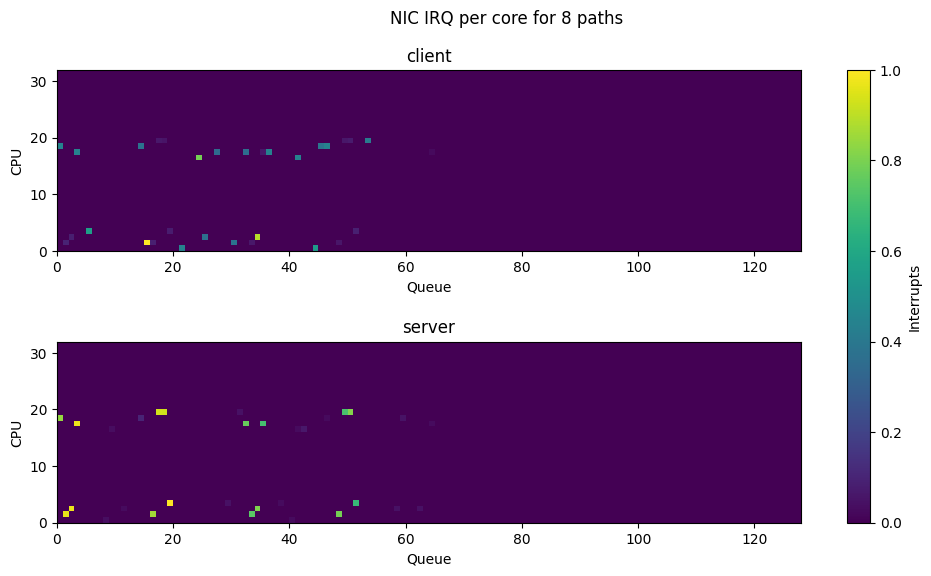

In [11]:
df_custom = df.loc[df["nb_paths"] == 11]
df_custom = df_custom[df_custom["implementation"] == "mcmpquic"]
df_custom = df_custom.drop(columns=["nb_paths", "implementation"], axis=1)
plot_rx_irq_per_cpu_core(df_custom, "NIC IRQ per core for 8 paths")
plt.savefig(os.path.join(plots_directory, "nic_irq_nb_paths_8.svg"), dpi=DPI, format="svg", bbox_inches="tight")
plt.savefig(os.path.join(plots_directory, "nic_irq_nb_paths_8.png"), dpi=DPI, format="png", bbox_inches="tight")

/tmp/ipykernel_23520/320341782.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivot_data = given_df.pivot_table(index='CPU', columns='queue', values='interrupts')
/tmp/ipykernel_23520/320341782.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivot_data = given_df.pivot_table(index='CPU', columns='queue', values='interrupts')


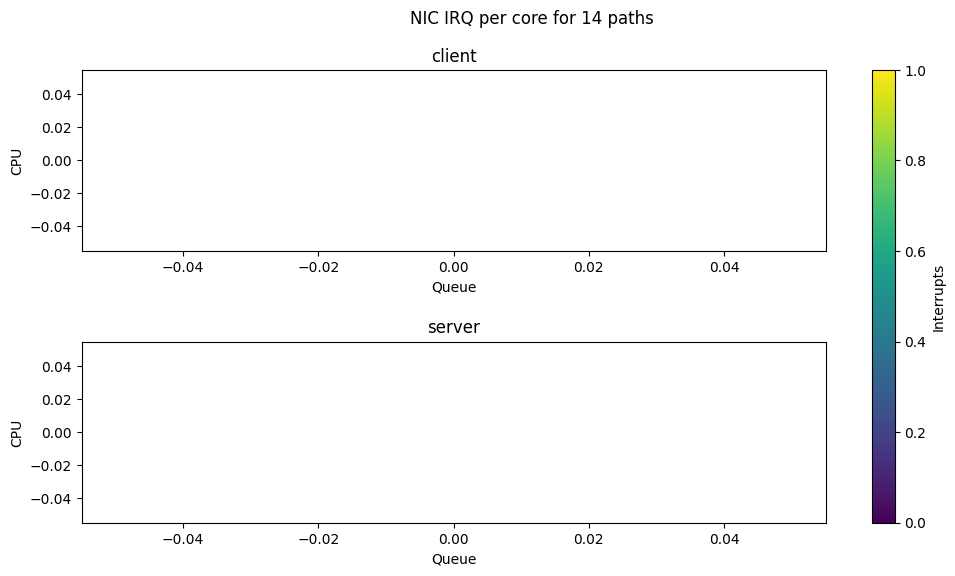

In [9]:
df_custom = df.loc[df["nb_paths"] == 14]
df_custom = df_custom[df_custom["implementation"] == "mcmpquic"]
df_custom = df_custom.drop(columns=["nb_paths", "implementation"], axis=1)
plot_rx_irq_per_cpu_core(df_custom, "NIC IRQ per core for 14 paths")
plt.savefig(os.path.join(plots_directory, "nic_irq_nb_paths_14.svg"), dpi=DPI, format="svg", bbox_inches="tight")
plt.savefig(os.path.join(plots_directory, "nic_irq_nb_paths_14.png"), dpi=DPI, format="png", bbox_inches="tight")

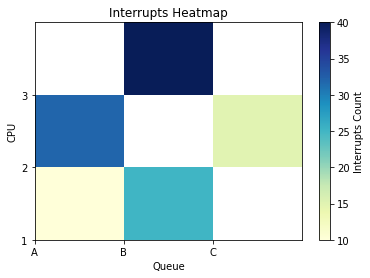

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual data)
data = {'CPU': [1, 1, 2, 2, 3],
        'queue': ['A', 'B', 'A', 'C', 'B'],
        'interrupts': [10, 25, 32, 15, 40]}
given_df = pd.DataFrame(data)

# Pivot table for heatmap data
pivot_data = given_df.pivot_table(index='CPU', columns='queue', values='interrupts')

# Create a new figure for plotting
fig, ax = plt.subplots()

# Create the heatmap using matplotlib
plt.pcolormesh(pivot_data, cmap='YlGnBu')  # Customize colormap as desired

# Add labels and title
plt.xlabel("Queue")
plt.ylabel("CPU")
plt.title("Interrupts Heatmap")

# Add colorbar (scale)
plt.colorbar(label="Interrupts Count")

# Set ticks and tick labels for axes (assuming CPUs and queues are unique)
plt.xticks(range(len(pivot_data.columns)), pivot_data.columns)
plt.yticks(range(len(pivot_data.index)), pivot_data.index)

# Display the heatmap
plt.show()
